<a href="https://colab.research.google.com/github/CGnal/agos-ai-course/blob/day5/day5/05_Graph_Neural_Networks_Node_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab\"/></a>

In [4]:
!pip install \
    ipywidgets \
    networkx \
    scikit-learn \
    matplotlib \
    pandas \
    scipy \
    tensorflow \
    stellargraph 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Node classification with GraphSAGE

Import stellargraph:

In [5]:
import networkx as nx
import pandas as pd
import os

import stellargraph as sg
from stellargraph.mapper import GraphSAGENodeGenerator
from stellargraph.layer import GraphSAGE

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection
from stellargraph import datasets
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

## Loading the CORA network

(See [the "Loading from Pandas" demo](../basics/loading-pandas.ipynb) for details on how data can be loaded.)

In [6]:
dataset = datasets.Cora()
display(HTML(dataset.description))
G, node_subjects = dataset.load()

- 2708 scientific pubblications
- 7 different classes 
- 5429 links

In [7]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5429

 Node types:
  paper: [2708]
    Features: float32 vector, length 1433
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5429]
        Weights: all 1 (default)
        Features: none


We aim to train a graph-ML model that will predict the "subject" attribute on the nodes. These subjects are one of 7 categories:

In [8]:
set(node_subjects)

{'Case_Based',
 'Genetic_Algorithms',
 'Neural_Networks',
 'Probabilistic_Methods',
 'Reinforcement_Learning',
 'Rule_Learning',
 'Theory'}

### Splitting the data

For machine learning we want to take a subset of the nodes for training, and use the rest for testing. We'll use scikit-learn again to do this

In [9]:
train_subjects, test_subjects = model_selection.train_test_split(
    node_subjects, train_size=0.1, test_size=None, stratify=node_subjects
)

Note using stratified sampling gives the following counts:

In [10]:
from collections import Counter

Counter(train_subjects)

Counter({'Probabilistic_Methods': 42,
         'Neural_Networks': 81,
         'Genetic_Algorithms': 42,
         'Case_Based': 30,
         'Reinforcement_Learning': 22,
         'Theory': 35,
         'Rule_Learning': 18})

The training set has class imbalance that might need to be compensated. However, we will ignore the class imbalance in this example, for simplicity.


### Converting to numeric arrays

For our categorical target, we will use one-hot vectors that will be fed into a soft-max Keras layer during training. To do this conversion ...

In [11]:
# we use Label Binarizer of sklearn package
target_encoding = preprocessing.LabelBinarizer()

train_targets = target_encoding.fit_transform(train_subjects)
test_targets = target_encoding.transform(test_subjects)

We now do the same for the node attributes we want to use to predict the subject. These are the feature vectors that the Keras model will use as input. The CORA dataset contains attributes 'w_x' that correspond to words found in that publication. If a word occurs more than once in a publication the relevant attribute will be set to one, otherwise it will be zero.

## Creating the GraphSAGE model in Keras

To feed data from the graph to the Keras model we need a data generator that feeds data from the graph to the model. The generators are specialized to the model and the learning task so we choose the `GraphSAGENodeGenerator` as we are predicting node attributes with a GraphSAGE model.

We need two other parameters, the `batch_size` to use for training and the number of nodes to sample at each level of the model. Here we choose a two-level model with 10 nodes sampled in the first layer, and 5 in the second.

In [12]:
batch_size = 50
num_samples = [10, 5]

A `GraphSAGENodeGenerator` object is required to send the node features in sampled subgraphs to Keras

In [13]:
generator = GraphSAGENodeGenerator(G, batch_size, num_samples)

Using the `generator.flow()` method, we can create iterators over nodes that should be used to train, validate, or evaluate the model. For training we use only the training nodes returned from our splitter and the target values. The `shuffle=True` argument is given to the `flow` method to improve training.

In [14]:
train_gen = generator.flow(train_subjects.index, train_targets, shuffle=True)

Now we can specify our machine learning model, we need a few more parameters for this:

 * the `layer_sizes` is a list of hidden feature sizes of each layer in the model. In this example we use 32-dimensional hidden node features at each layer.
 * The `bias` and `dropout` are internal parameters of the model. 

In [15]:
graphsage_model = GraphSAGE(
    layer_sizes=[32, 32], generator=generator, bias=True, dropout=0.5,
)

Now we create a model to predict the 7 categories using Keras softmax layers.

In [16]:
x_inp, x_out = graphsage_model.in_out_tensors()
prediction = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)

In [17]:
x_inp

[<KerasTensor: shape=(None, 1, 1433) dtype=float32 (created by layer 'input_1')>,
 <KerasTensor: shape=(None, 10, 1433) dtype=float32 (created by layer 'input_2')>,
 <KerasTensor: shape=(None, 50, 1433) dtype=float32 (created by layer 'input_3')>]

In [18]:
x_out

<KerasTensor: shape=(None, 32) dtype=float32 (created by layer 'lambda')>

In [19]:
prediction

<KerasTensor: shape=(None, 7) dtype=float32 (created by layer 'dense')>

### Training the model

Now let's create the actual Keras model with the graph inputs `x_inp` provided by the `graph_model` and outputs being the predictions from the softmax layer

In [20]:
model = Model(inputs=x_inp, outputs=prediction)
model.compile(
    optimizer=optimizers.Adam(lr=0.005),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

Train the model, keeping track of its loss and accuracy on the training set, and its generalisation performance on the test set (we need to create another generator over the test data for this)

In [21]:
test_gen = generator.flow(test_subjects.index, test_targets)

In [22]:
history = model.fit(
    train_gen, epochs=20, validation_data=test_gen, verbose=2, shuffle=False
)

Epoch 1/20
6/6 - 4s - loss: 1.8946 - acc: 0.2556 - val_loss: 1.6680 - val_acc: 0.4295
Epoch 2/20
6/6 - 2s - loss: 1.6132 - acc: 0.4815 - val_loss: 1.5112 - val_acc: 0.4947
Epoch 3/20
6/6 - 2s - loss: 1.4244 - acc: 0.6852 - val_loss: 1.3600 - val_acc: 0.6961
Epoch 4/20
6/6 - 2s - loss: 1.2761 - acc: 0.8444 - val_loss: 1.2444 - val_acc: 0.7625
Epoch 5/20
6/6 - 2s - loss: 1.1449 - acc: 0.8852 - val_loss: 1.1403 - val_acc: 0.7670
Epoch 6/20
6/6 - 2s - loss: 0.9970 - acc: 0.9444 - val_loss: 1.0579 - val_acc: 0.7736
Epoch 7/20
6/6 - 2s - loss: 0.9061 - acc: 0.9519 - val_loss: 0.9901 - val_acc: 0.7990
Epoch 8/20
6/6 - 2s - loss: 0.8182 - acc: 0.9519 - val_loss: 0.9340 - val_acc: 0.8015
Epoch 9/20
6/6 - 2s - loss: 0.7286 - acc: 0.9667 - val_loss: 0.8830 - val_acc: 0.8084
Epoch 10/20
6/6 - 3s - loss: 0.6479 - acc: 0.9778 - val_loss: 0.8424 - val_acc: 0.8056
Epoch 11/20
6/6 - 2s - loss: 0.5964 - acc: 0.9741 - val_loss: 0.8173 - val_acc: 0.8031
Epoch 12/20
6/6 - 2s - loss: 0.5211 - acc: 0.9852 - 

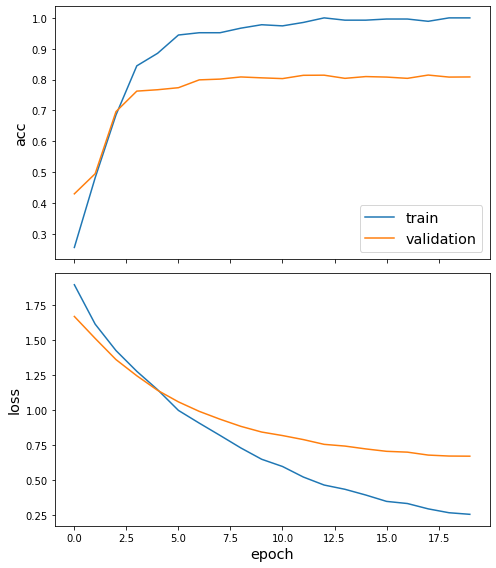

In [23]:
sg.utils.plot_history(history)

Now we have trained the model we can evaluate on the test set.

In [24]:
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

49/49 [==============================] - 2s 36ms/step - loss: 0.6683 - acc: 0.8162

Test Set Metrics:
	loss: 0.6683
	acc: 0.8162


### Making predictions with the model

Now let's get the predictions themselves for all nodes using another node iterator:

In [25]:
all_nodes = node_subjects.index
all_mapper = generator.flow(all_nodes)
all_predictions = model.predict(all_mapper)

These predictions will be the output of the softmax layer, so to get final categories we'll use the `inverse_transform` method of our target attribute specification to turn these values back to the original categories

In [26]:
node_predictions = target_encoding.inverse_transform(all_predictions)

Let's have a look at a few:

In [27]:
df = pd.DataFrame({"Predicted": node_predictions, "True": node_subjects})
df.head(10)

,Predicted,True
31336,Theory,Neural_Networks
1061127,Rule_Learning,Rule_Learning
1106406,Reinforcement_Learning,Reinforcement_Learning
13195,Reinforcement_Learning,Reinforcement_Learning
37879,Probabilistic_Methods,Probabilistic_Methods
1126012,Reinforcement_Learning,Probabilistic_Methods
1107140,Reinforcement_Learning,Theory
1102850,Theory,Neural_Networks
31349,Theory,Neural_Networks
1106418,Theory,Theory


## Node embeddings
Evaluate node embeddings as activations of the output of GraphSAGE layer stack, and visualise them, coloring nodes by their subject label.

The GraphSAGE embeddings are the output of the GraphSAGE layers, namely the `x_out` variable. Let's create a new model with the same inputs as we used previously `x_inp` but now the output is the embeddings rather than the predicted class. Additionally note that the weights trained previously are kept in the new model.

In [28]:
embedding_model = Model(inputs=x_inp, outputs=x_out)

In [29]:
emb = embedding_model.predict(all_mapper)
emb.shape

(2708, 32)

Project the embeddings to 2d using either TSNE or PCA transform, and visualise, coloring nodes by their subject label

In [30]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np

In [31]:
X = emb
y = np.argmax(target_encoding.transform(node_subjects), axis=1)

In [32]:
if X.shape[1] > 2:
    transform = TSNE  # PCA

    trans = transform(n_components=2)
    emb_transformed = pd.DataFrame(trans.fit_transform(X), index=node_subjects.index)
    emb_transformed["label"] = y
else:
    emb_transformed = pd.DataFrame(X, index=node_subjects.index)
    emb_transformed = emb_transformed.rename(columns={"0": 0, "1": 1})
    emb_transformed["label"] = y

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


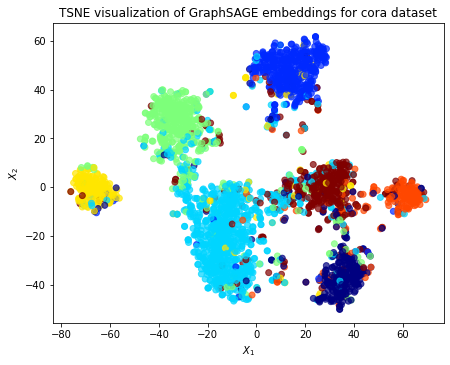

In [33]:
alpha = 0.7

fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(
    emb_transformed[0],
    emb_transformed[1],
    c=emb_transformed["label"].astype("category"),
    cmap="jet",
    alpha=alpha,
)
ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
plt.title(
    "{} visualization of GraphSAGE embeddings for cora dataset".format(transform.__name__)
)
plt.show()